In [1]:
import pybullet as p
import numpy as np
from transforms3d.quaternions import *
from transforms3d.euler import *
from transforms3d.axangles import *
import sys
import os
import json
import open3d as o3d
import matplotlib.pyplot as plt

sys.path.append("../")
from env.ycb_scene import SimulatedYCBEnv

pybullet build time: Dec  1 2021 18:33:43


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
'''
get data file name in json file and load mesh in pybullet
then reset robot and object position
'''

file = os.path.join("../object_index", 'ycb_large.json')
with open(file) as f: file_dir = json.load(f)
file_dir = file_dir['test']
file_dir = [f[:-5].split('.')[0][:-2] for f in file_dir]
test_file_dir = list(set(file_dir))

env = SimulatedYCBEnv()
env._load_index_objs(test_file_dir)
state = env.reset(save=False, enforce_face_target=True)

/home/ros/Downloads/TM5_900_pybullet/env/models
>>>> target name: 010_potted_meat_can


In [3]:
def scenes_check():
    for uid in np.array(env._objectUids)[np.array(env.placed_objects)]:
        if p.getBasePositionAndOrientation(uid)[0][2] < env.table_pos[2]:
            return False
    if not env.stack_success:
        return False
    return True

In [5]:
# How many times to reset scene if object reset failed
reset_times = 5
# Number of object put on table
num_object = 5
# If object in table scene be uniformly placed
stack = False

# Reset environment without reload object mesh, set "reset_free=True"
for _ in range(reset_times):
    state = env.reset(save=False, reset_free=True, num_object=num_object, if_stack=stack)
    if not scenes_check():
        state = env.reset(save=False, reset_free=True, num_object=num_object, if_stack=stack)
    else:
        break

>>>> target name: 004_sugar_box
>>>> target name: 021_bleach_cleanser
>>>> target name: 006_mustard_bottle
>>>> target name: 003_cracker_box
>>>> target name: 061_foam_brick


In [6]:
placed_obj = {}
placed_idx = np.where(np.array(env.placed_objects))[0]
placed_name = np.array(env.obj_indexes)[np.where(np.array(env.placed_objects))]
for i in range(num_object):
    placed_obj[placed_idx[i]] = placed_name[i]
print(placed_obj)

{0: '021_bleach_cleanser', 1: '003_cracker_box', 2: '061_foam_brick', 4: '004_sugar_box', 6: '006_mustard_bottle'}


## Get environment observation in multi-object scenario

User must specify env.target_idx before any process in robot task. The variable target_idx will effect entire environment setting and API, including image pre-processing, point cloud extraction, and object lifted detection in env.retract().

0 021_bleach_cleanser
1 003_cracker_box
2 061_foam_brick
4 004_sugar_box
6 006_mustard_bottle


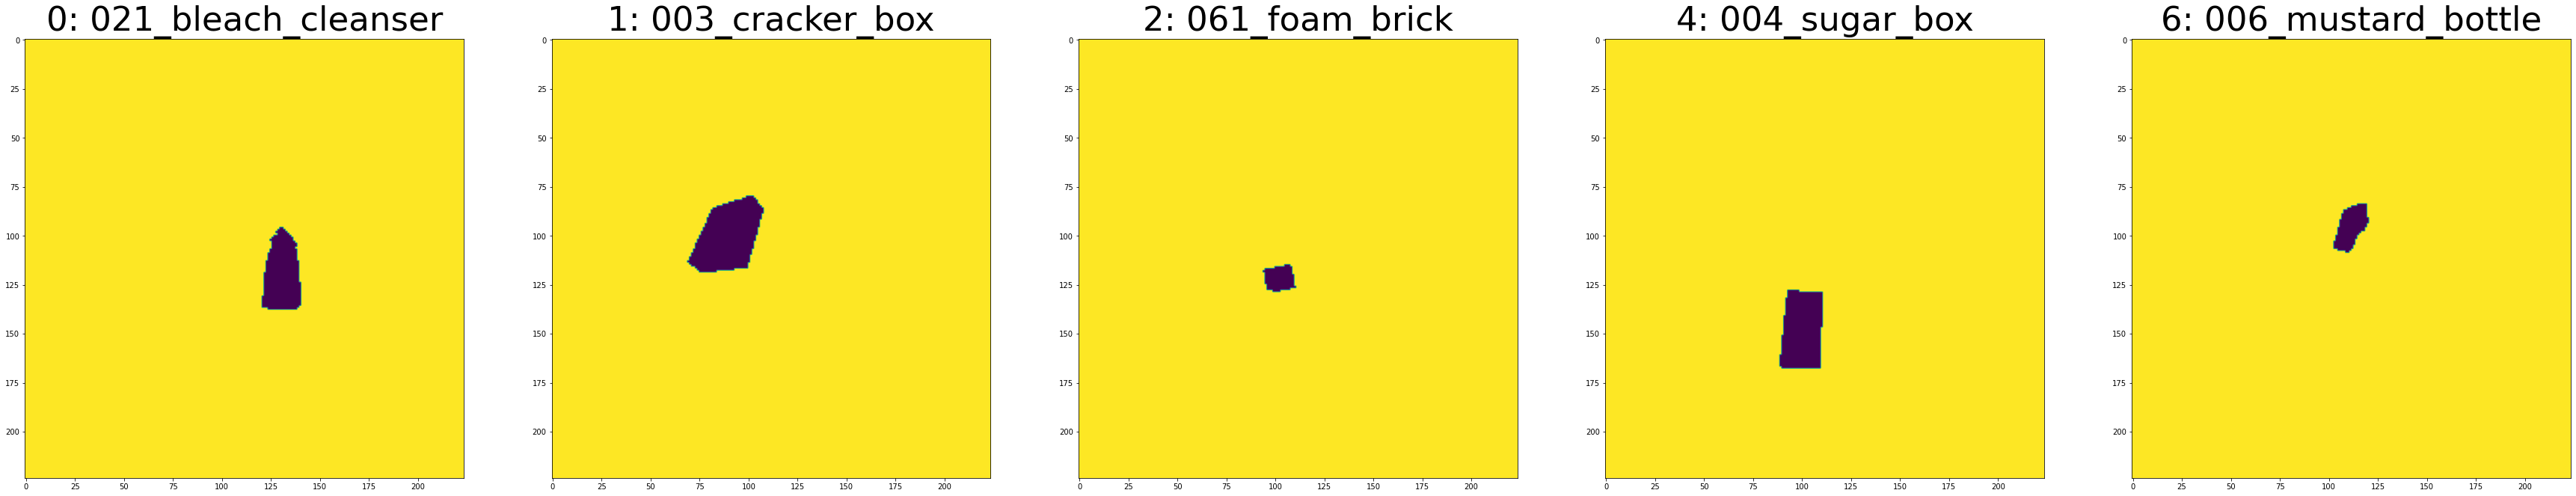

In [7]:
fig=plt.figure(figsize=(61, 61))
for i, index in enumerate(placed_obj.keys()):
    name = placed_obj[index]

    #Specify target_idx before get observation
    env.target_idx = index
    obs, _, _, _ = env._get_observation()
    fig.add_subplot(1, num_object, i+1)

    # Show image mask of each object
    plt.imshow(obs[1][4].T)
    plt.title(f"{index}: {name}", fontsize=45) 
    print(index, name)
plt.show()